# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        # if activation != 0:
        #     return tf.nn.softmax(y)
        # else:
        #     return tf.nn.sigmoid(y)
        if activation == 'sigmoid':
            return tf.nn.sigmoid(y)
        elif activation == 'softmax':
            return tf.nn.softmax(y)
        else:
            return y

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.dense1 = DenseLayer(num_features, n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.dense2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.dense1(x, activation='sigmoid')
    x = self.dense2(x, activation='sigmoid')
    x = self.out_layer(x, activation='softmax')
    return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    # return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Порівнюємо передбачення та істинні значення
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = [neural_net.dense1.w, neural_net.dense1.b,
                               neural_net.dense2.w, neural_net.dense2.b,
                               neural_net.out_layer.w, neural_net.out_layer.b]

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Step: {step}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Step: 100, Loss: 10.8082, Accuracy: 0.1172
Step: 200, Loss: 10.3471, Accuracy: 0.0898
Step: 300, Loss: 8.4364, Accuracy: 0.1250
Step: 400, Loss: 8.3482, Accuracy: 0.1055
Step: 500, Loss: 7.6024, Accuracy: 0.1250
Step: 600, Loss: 6.8341, Accuracy: 0.1211
Step: 700, Loss: 6.1565, Accuracy: 0.1445
Step: 800, Loss: 6.2011, Accuracy: 0.1328
Step: 900, Loss: 6.1645, Accuracy: 0.1172
Step: 1000, Loss: 6.1927, Accuracy: 0.1562
Step: 1100, Loss: 6.1497, Accuracy: 0.1406
Step: 1200, Loss: 5.9439, Accuracy: 0.1484
Step: 1300, Loss: 5.3073, Accuracy: 0.1719
Step: 1400, Loss: 5.0634, Accuracy: 0.1875
Step: 1500, Loss: 5.5148, Accuracy: 0.1523
Step: 1600, Loss: 5.3383, Accuracy: 0.1875
Step: 1700, Loss: 5.0516, Accuracy: 0.1680
Step: 1800, Loss: 5.0148, Accuracy: 0.1992
Step: 1900, Loss: 5.1200, Accuracy: 0.1914
Step: 2000, Loss: 4.9163, Accuracy: 0.2188
Step: 2100, Loss: 4.6386, Accuracy: 0.2539
Step: 2200, Loss: 4.6648, Accuracy: 0.2383
Step: 2300, Loss: 4.4268, Accuracy: 0.2461
Step: 2400, Loss: 

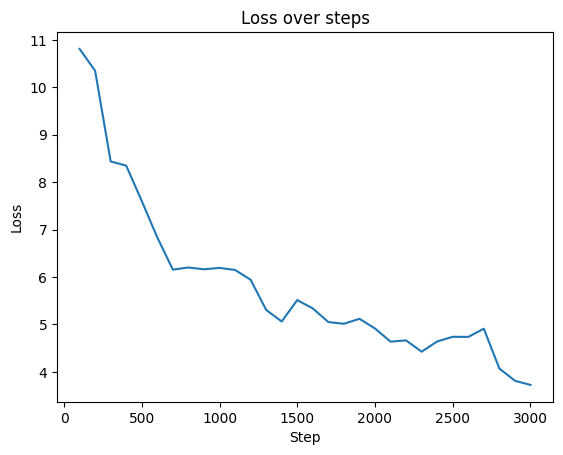

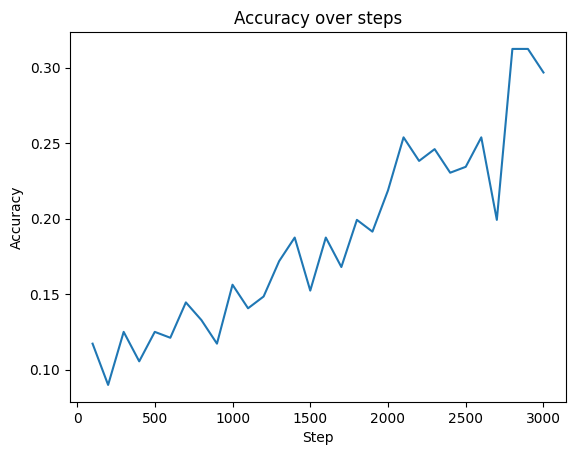

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(range(display_step, training_steps + 1, display_step), loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over steps')
plt.show()

# Виведіть графік точності
plt.plot(range(display_step, training_steps + 1, display_step), accuracy_history)
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Accuracy over steps')
plt.show()


In [16]:
# Обчисліть точність навченої нейромережі
# Місце для вашого коду
# Тестування моделі на тестових даних
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
test_acc = []
for batch_x, batch_y in test_data:
    pred = neural_net(batch_x)
    acc = accuracy(pred, batch_y)
    test_acc.append(acc)
print(f"Test Accuracy: {np.mean(test_acc):.4f}")

Test Accuracy: 0.2731


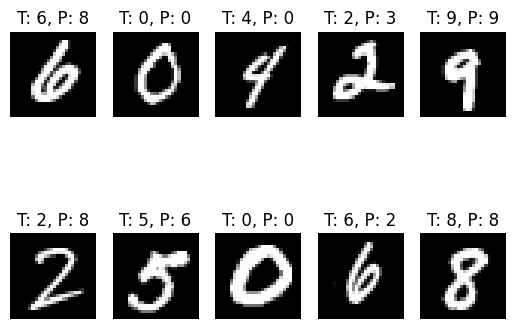

In [17]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

num_images = 10
test_images = random.sample(list(zip(x_test, y_test)), num_images)
for i, (image, label) in enumerate(test_images):
    image = image.reshape(1, -1)
    pred = neural_net(image)
    pred_label = tf.argmax(pred, axis=1).numpy()[0]
    plt.subplot(2, 5, i+1)
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f"T: {label}, P: {pred_label}")
    plt.axis('off')
plt.show()




In [21]:
# Отримати передбачення для всіх тестових даних
y_pred = []
y_true = []

for batch_x, batch_y in test_data:
    pred = neural_net(batch_x)
    y_pred.extend(tf.argmax(pred, axis=1).numpy())
    y_true.extend(batch_y.numpy())

# Використати classification_report для створення звіту
report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)])
print(report)

              precision    recall  f1-score   support

           0       0.31      0.32      0.31       980
           1       0.61      0.59      0.60      1135
           2       0.24      0.23      0.23      1032
           3       0.25      0.26      0.25      1010
           4       0.19      0.18      0.19       982
           5       0.09      0.09      0.09       892
           6       0.15      0.14      0.14       958
           7       0.28      0.30      0.29      1028
           8       0.24      0.24      0.24       974
           9       0.29      0.31      0.30      1009

    accuracy                           0.27     10000
   macro avg       0.26      0.27      0.26     10000
weighted avg       0.27      0.27      0.27     10000



In [24]:
import pandas as pd
from sklearn.metrics import classification_report
from tabulate import tabulate

# Генеруємо classification report
report_dict = classification_report(y_true, y_pred, output_dict=True)

# Перетворюємо report на DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Округлюємо показники до двох знаків
report_df = report_df.round(2)

# Виведення таблиці у красивому форматі
print(tabulate(report_df, headers='keys', tablefmt='pretty'))

+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.31    |  0.32  |   0.31   |  980.0  |
|      1       |   0.61    |  0.59  |   0.6    | 1135.0  |
|      2       |   0.24    |  0.23  |   0.23   | 1032.0  |
|      3       |   0.25    |  0.26  |   0.25   | 1010.0  |
|      4       |   0.19    |  0.18  |   0.19   |  982.0  |
|      5       |   0.09    |  0.09  |   0.09   |  892.0  |
|      6       |   0.15    |  0.14  |   0.14   |  958.0  |
|      7       |   0.28    |  0.3   |   0.29   | 1028.0  |
|      8       |   0.24    |  0.24  |   0.24   |  974.0  |
|      9       |   0.29    |  0.31  |   0.3    | 1009.0  |
|   accuracy   |   0.27    |  0.27  |   0.27   |  0.27   |
|  macro avg   |   0.26    |  0.27  |   0.26   | 10000.0 |
| weighted avg |   0.27    |  0.27  |   0.27   | 10000.0 |
+--------------+-----------+--------+----------+--------

Виходячи з наданих метрик якості роботи нейронної мережі, можна зробити наступні висновки:

1. **Низька загальна точність**:
   - Загальна точність моделі становить 27%, що є досить низьким показником для класифікації цифр MNIST. Це означає, що модель правильно класифікує лише 27% всіх тестових зразків.

2. **Низька точність (precision)**:
   - Precision для різних класів коливається від 0.09 (для цифри 5) до 0.61 (для цифри 1). Це свідчить про те, що модель часто видає хибно позитивні передбачення, особливо для деяких цифр.

3. **Низька повнота (recall)**:
   - Recall для різних класів також є низьким і варіюється від 0.09 (для цифри 5) до 0.59 (для цифри 1). Це означає, що модель часто не виявляє справжні позитивні зразки.

4. **Низький F1-Score**:
   - F1-Score для всіх класів також низький, коливаючись від 0.09 до 0.60. Це свідчить про те, що і precision, і recall для всіх класів є незадовільними.

5. **Проблеми з класифікацією конкретних цифр**:
   - Цифра 5 має найнижчі метрики (precision, recall і F1-Score), що свідчить про значні труднощі моделі з розпізнаванням цієї цифри.
   - Цифра 1 має найвищі метрики, але навіть вони не є достатньо високими для задовільної класифікації.

6. **Макро і зважені середні метрики**:
   - Макро середнє значення (macro avg) для всіх метрик є низьким (близько 0.26-0.27), що свідчить про те, що модель не вдається добре розпізнавати жоден з класів.
   - Зважене середнє значення (weighted avg) також є низьким і вказує на те, що модель має проблеми з класифікацією навіть при врахуванні різної кількості зразків кожного класу.

### Можливі причини низької якості моделі:

1. **Недостатня складність моделі**:
   - Модель з двома прихованими шарами може бути недостатньо складною для ефективного навчання на датасеті MNIST.

2. **Недостатнє навчання**:
   - Модель могла недостатньо навчатися, можливо, через недостатню кількість епох чи недостатній розмір batch.

3. **Невідповідні гіперпараметри**:
   - Низька швидкість навчання або неправильні початкові ваги можуть призводити до поганого результату.

4. **Проблеми з нормалізацією даних**:
   - Хоча нормалізація пікселів була виконана, можливо, інші аспекти підготовки даних потребують уваги.

### Рекомендації:

1. **Покращення архітектури моделі**:
   - Додати більше шарів або збільшити кількість нейронів в кожному шарі.
   - Спробувати інші активаційні функції, такі як ReLU.

2. **Покращення процесу навчання**:
   - Збільшити кількість епох навчання.
   - Використовувати інші оптимізатори, такі як Adam, які можуть швидше знаходити оптимальні ваги.

3. **Тонке налаштування гіперпараметрів**:
   - Випробувати різні значення швидкості навчання.
   - Використовувати регуляризацію (наприклад, Dropout) для запобігання перенавчанню.

4. **Покращення підготовки даних**:
   - Виконати додаткові перетворення зображень, такі як аугментація даних.

Загалом, поточна модель має значні проблеми з класифікацією і потребує суттєвих покращень для досягнення прийнятної точності.